This notebook reproduces figures from LungNENomics manuscript, Supplementary Figure 19 (spatial transcriptomics)

In [46]:
import pandas as pd
import scanpy as sc
import liana as li
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colorbar
import seaborn as sns
import squidpy as sq
from scipy.sparse import csr_matrix, isspmatrix_csr
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

import spatial_correlation as sp_corr

import anndata as ad

### Load AnnData of lung spatial slides annotated by IRIS domains and a csv with cell type proportions (IRIS deconvolution)

In [3]:
# load data
lung_A = ad.read_h5ad('../data/annotated_slice1_NEW.h5ad')
lung_B = ad.read_h5ad('../data/annotated_slice2_NEW.h5ad')
lung_C = ad.read_h5ad('../data/annotated_slice3_NEW.h5ad')
lung_D = ad.read_h5ad('../data/annotated_slice4_NEW.h5ad')


sc.pp.normalize_total(lung_A, target_sum=1e4)
sc.pp.log1p(lung_A)

sc.pp.normalize_total(lung_B, target_sum=1e4)
sc.pp.log1p(lung_B)

sc.pp.normalize_total(lung_C, target_sum=1e4)
sc.pp.log1p(lung_C)

sc.pp.normalize_total(lung_D, target_sum=1e4)
sc.pp.log1p(lung_D)

In [4]:
IRIS_df = pd.read_csv('../cellchat/IRIS proportions/IRIS_proportions_NEW.csv')

### Process data

In [11]:
# separate IRIS data by slices
sample_names = IRIS_df["Slice"].unique()
print("Sample names: ", sample_names)

IRIS_prop1 = IRIS_df[IRIS_df["Slice"]==sample_names[0]]
IRIS_prop2 = IRIS_df[IRIS_df["Slice"]==sample_names[1]]
IRIS_prop3 = IRIS_df[IRIS_df["Slice"]==sample_names[2]]
IRIS_prop4 = IRIS_df[IRIS_df["Slice"]==sample_names[3]]

# set index as spot barcode for concatenation
IRIS_prop1.set_index("spotName", inplace=True)
IRIS_prop2.set_index("spotName", inplace=True)
IRIS_prop3.set_index("spotName", inplace=True)
IRIS_prop4.set_index("spotName", inplace=True)

IRIS_proportions = [IRIS_prop1, IRIS_prop2, IRIS_prop3, IRIS_prop4]

types_to_plot = ["Lower Airway Progenitor",
                    "Neuroendocrine CALCA+", "Neuroendocrine NEUROD1+", "Club",
                    "Macrophage", "Macrophage_proliferating",
                    "Myofibro", "Fibro", "T_conv", "T_CD8", "T/NK_proliferating"]

# keep cell types we are interested to plot
for i in range(len(IRIS_proportions)):
    IRIS_proportions[i] = IRIS_proportions[i][types_to_plot]
    # if we want to rescale the proportions (from 0 to 1)
    #IRIS_proportions[i] = (IRIS_proportions[i] - IRIS_proportions[i].min()) / (IRIS_proportions[i].max() - IRIS_proportions[i].min())
    #IRIS_list.append(IRIS_proportions[i])

# Add  IRIS proportions to lung AnnData obs

lung_A_copy = lung_A.copy()
lung_B_copy = lung_B.copy()
lung_C_copy = lung_C.copy()
lung_D_copy = lung_D.copy()

lung_slices = [lung_A_copy, lung_B_copy, lung_C_copy, lung_D_copy]

# concatenate metadata of spatial samples with IRIS proportions
for i, lung_slice in enumerate(lung_slices):
    overlapping_cols = lung_slice.obs.columns.intersection(IRIS_proportions[i].columns)
    iris_data = IRIS_proportions[i].drop(columns=overlapping_cols)
    lung_slice.obs = pd.concat([lung_slice.obs, iris_data], join="inner", axis=1)
    

Sample names:  ['LNEN071-IARC-A' 'LNEN084-IARC-B' 'LNEN107-IARC-C' 'LNEN206-IARC-D']


In [13]:
# check the .obs of lung AnnData

lung_slices[0].obs.head()

in_tissue           Slice     x     y IRIS_domain  \
AAACAAGTATCTCCCA-1          1  LNEN071-IARC-A  1125   745           9   
AAACACCAATAACTGC-1          1  LNEN071-IARC-A   819  2342           5   
AAACAGAGCGACTCCT-1          1  LNEN071-IARC-A  2331   902           1   
AAACAGGGTCTATATT-1          1  LNEN071-IARC-A  1220  2459          15   
AAACAGTGTTCCTGGG-1          1  LNEN071-IARC-A   351  1878           4   

                    Lower Airway Progenitor  Neuroendocrine CALCA+  \
AAACAAGTATCTCCCA-1                 0.045313               0.100504   
AAACACCAATAACTGC-1                 0.043353               0.112336   
AAACAGAGCGACTCCT-1                 0.050724               0.101191   
AAACAGGGTCTATATT-1                 0.044481               0.110098   
AAACAGTGTTCCTGGG-1                 0.039686               0.090931   

                    Neuroendocrine NEUROD1+      Club  Macrophage  \
AAACAAGTATCTCCCA-1                 0.124230  0.056875    0.006491   
AAACACCAATAACTGC-1                 0.112434  0.060388    0.006398   
AAACAGAGCGACTCCT-1                 0.110583  0.060136    0.007742   
AAACAGGGTCTATATT-1                 0.124447  0.055594    0.005613   
AAACAGTGTTCCTGGG-1                 0.103889  0.057626    0.009553   

                    Macrophage_proliferating  Myofibro     Fibro    T_conv  \
AAACAAGTATCTCCCA-1                  0.003286  0.032961  0.015508  0.024333   
AAACACCAATAACTGC-1                  0.005865  0.030516  0.015529  0.023250   
AAACAGAGCGACTCCT-1                  0.003710  0.029531  0.016782  0.022671   
AAACAGGGTCTATATT-1                  0.006802  0.029044  0.015230  0.026180   
AAACAGTGTTCCTGGG-1                  0.008651  0.048366  0.024972  0.021085   

                       T_CD8  T/NK_proliferating  
AAACAAGTATCTCCCA-1  0.021921            0.016546  
AAACACCAATAACTGC-1  0.018389            0.014417  
AAACAGAGCGACTCCT-1  0.018316            0.018144  
AAACAGGGTCTATATT-1  0.020079            0.017085  
AAACAGTGTTCCTGGG-1  0.020739            0.015938

### Plot figures

#### IRIS spatial domains

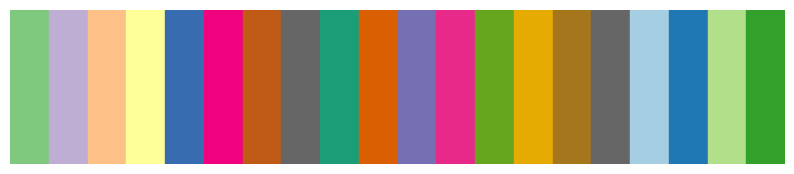

In [14]:
# set colors consistent with spatial domains figure produced with R

r_colors = [
    "#7FC97F", "#BEAED4", "#FDC086", "#FFFF99", "#386CB0", "#F0027F", "#BF5B17", "#666666",
    "#1B9E77", "#D95F02", "#7570B3", "#E7298A", "#66A61E", "#E6AB02", "#A6761D", "#666666",
    "#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C"
]

fig, ax = plt.subplots(figsize=(10, 2))
for i, color in enumerate(r_colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    
ax.set_xlim(0, len(r_colors))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.show()

colors_IRIS = {}
for i, color in enumerate(r_colors):
    colors_IRIS[str(i)]=color

custom_cmap = mcolors.ListedColormap(colors_IRIS)


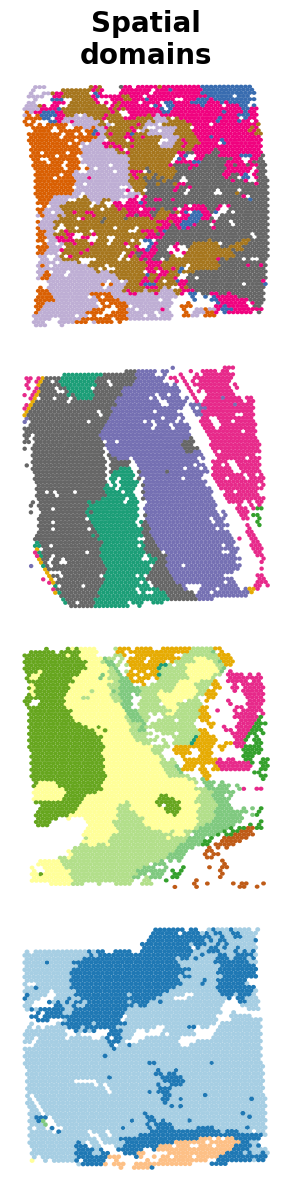

In [ ]:
# plot spatial domains

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(3,12))

for i, lung_slice in enumerate(lung_slices):
    sc.pl.spatial(lung_slice, 
                  color=['IRIS_domain'], 
                  size=1.7, 
                  palette=colors_IRIS, 
                  img_key=None, 
                  show=False, 
                  ax=ax[i],
                  title="", 
                  frameon=False, 
                  #hspace=0.05
                )
    if ax[i].get_legend() is not None:
        ax[i].get_legend().remove()
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_aspect("auto")
ax[0].set_title("Spatial\ndomains", fontsize=20, fontweight='bold')    
plt.tight_layout(pad=1)

plt.savefig("spatial_domains.png", format="png", bbox_inches="tight", dpi=300)

#### Plot proportions of cells of origin and LAP markers

In [16]:
NE_cells = ['Lower Airway Progenitor', "Club", 'Neuroendocrine CALCA+', 'Neuroendocrine NEUROD1+']

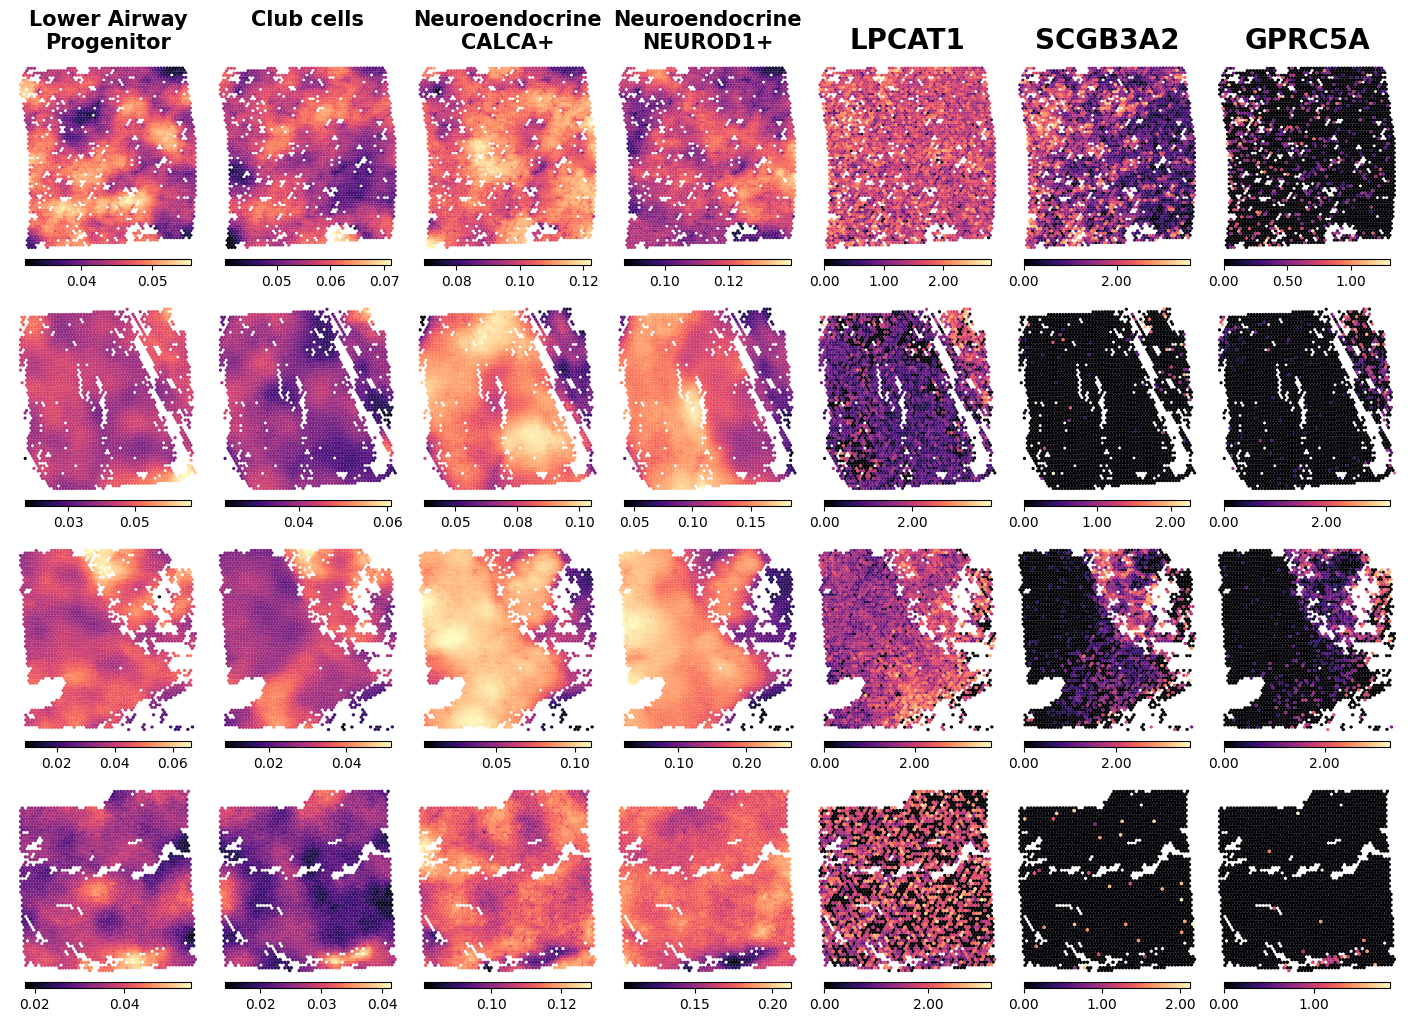

In [17]:
#fig, ax = plt.subplots(nrows=4, ncols=7, figsize=(24,11))
fig = plt.figure(figsize=(18, 12))

# plot pathway scores
gs = gridspec.GridSpec(nrows=4, ncols=7)

# Create a 4x4 subplot grid
ax = [[fig.add_subplot(gs[i, j]) for j in range(7)] for i in range(4)]

col_num = 0

# plot cells of origin
cells_for_plot = ["Lower Airway\nProgenitor", "Club cells\n", "Neuroendocrine\nCALCA+", "Neuroendocrine\nNEUROD1+"]

for j, col_name in enumerate(NE_cells):
    for i, lung_slice in enumerate(lung_slices):
        im = sc.pl.spatial(lung_slice, color=[col_name], 
                size=1.7, cmap="magma", 
                img_key=None, 
                return_fig=True, 
                show=False, ax=ax[i][col_num], title="", 
                frameon=False,
                #vmin=NE_minmax_prop[col_name]["vmin"],
                #vmax=NE_minmax_prop[col_name]["vmax"],
                colorbar_loc = None
                )
        
        if ax[i][col_num].get_legend() is not None:
            ax[i][col_num].get_legend().remove()
        ax[i][col_num].set_xlabel("")
        ax[i][col_num].set_ylabel("")
        ax[i][col_num].set_aspect("auto")
        
        # Add column title to each subplot
        if i == 0:  # Add titles only to the first row (or based on your preference)
            ax[i][col_num].set_title(cells_for_plot[j], fontsize=15, fontweight='bold')  # Customize title as needed
        
        
        # Create colorbar outside the plots
        axins = inset_axes(ax[i][col_num],
                        width="85%",  
                        height="3%",
                        loc='lower center',
                        borderpad=-0.5
                        )
        cb=fig.colorbar(ax[i][col_num].collections[0], cax=axins, orientation="horizontal", format="{x:.2f}")
        cb.ax.tick_params(labelsize=10) 
    col_num += 1
        
        
# plot LAP markers 
for j, marker in enumerate(["LPCAT1", "SCGB3A2", "GPRC5A"]):
    #col_num += 1
    for i, lung_data in enumerate(lung_slices):
        sc.pl.spatial(lung_data, color=marker, 
                        size=1.7, 
                        cmap="magma", 
                        img_key=None, 
                        return_fig=True, 
                        show=False, 
                        ax=ax[i][col_num], 
                        title="", 
                        frameon=False, 
                        colorbar_loc = None
                        )
        ax[i][col_num].set_aspect("auto")
        if i == 0:  # Add titles only to the first row (or based on your preference)
            ax[i][col_num].set_title(marker, fontsize=20, fontweight='bold')  # Customize title as needed

        axins = inset_axes(ax[i][col_num],
                        width="85%",  
                        height="3%",
                        loc='lower center',
                        borderpad=-0.5
                        )
    
        cb = fig.colorbar(ax[i][col_num].collections[0], cax=axins, orientation="horizontal", format="{x:.2f}")
        cb.ax.tick_params(labelsize=10) 

    col_num += 1

plt.subplots_adjust(wspace=0.02, hspace=0.2)  # Adjust horizontal (wspace) and vertical (hspace) spacing
#plt.savefig("spatial_plot_NE_LAP.png", format="png", bbox_inches="tight", dpi=300)

#### Plot immune cells proportions: macrophages, fibroblasts, T-cells

In [18]:
# merge macrophage, fibroblast and T-cells subtypes
for i, lung_slice in enumerate(lung_slices):
    lung_slice.obs["Macrophages"] = lung_slice.obs["Macrophage"] + lung_slice.obs["Macrophage_proliferating"]

    lung_slice.obs["Fibroblasts"] = lung_slice.obs["Myofibro"] + lung_slice.obs["Fibro"]

    lung_slice.obs["T-cells"] = lung_slice.obs["T_conv"] + lung_slice.obs["T_CD8"] + lung_slice.obs["T/NK_proliferating"]    

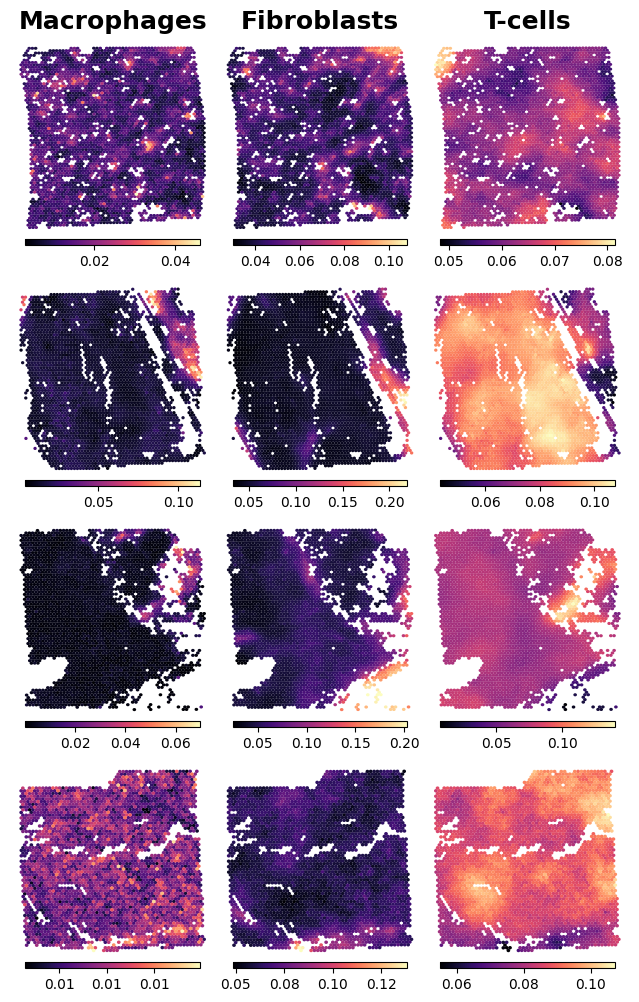

In [22]:
immune_cells = ["Macrophages", "Fibroblasts", "T-cells"]

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(8,12))

for j, col_name in enumerate(immune_cells):
    for i, lung_slice in enumerate(lung_slices):
        sc.pl.spatial(lung_slice, 
                      color=[col_name], 
                      size=1.7, 
                      cmap="magma", 
                      img_key=None, 
                      return_fig=True, 
                      show=False, 
                      ax=ax[i][j], 
                      title="", 
                      frameon=False, 
                      hspace=0.05,
                      colorbar_loc = None
                    )
        if ax[i][j].get_legend() is not None:
            ax[i][j].get_legend().remove()
        ax[i][j].set_xlabel("")
        ax[i][j].set_ylabel("")
        ax[i][j].set_aspect("auto")

        # Add column title to each subplot
        if i == 0:  # Add titles only to the first row (or based on your preference)
            ax[i][j].set_title(col_name, fontsize=18, fontweight='bold')  # Customize title as needed

        #cbar = g.figure.colorbar(g.collections[0], location="right", fraction=0.02, pad=0.25)
        axins = inset_axes(ax[i][j],
                        width="85%",  
                        height="3%",
                        loc='lower center',
                        borderpad=-0.5
                        )
    
        cb = fig.colorbar(ax[i][j].collections[0], cax=axins, orientation="horizontal", format="{x:.2f}")
        cb.ax.tick_params(labelsize=10) 

plt.subplots_adjust(wspace=0.01, hspace=0.2)  # Adjust horizontal (wspace) and vertical (hspace) spacing

plt.savefig("Immune_prop.png", format="png", bbox_inches="tight", dpi=300)

#### Plot interaction scores for inferred signalling pathways (top scored interactions)

In [25]:
# load pathway scores
top_inter1 = pd.read_csv("../cellchat/CellChat interactions/100top_inter_slice1_prob_NEW.csv", index_col=False)
top_inter2 = pd.read_csv("../cellchat/CellChat interactions/100top_inter_slice2_prob_NEW.csv", index_col=False)
top_inter3 = pd.read_csv("../cellchat/CellChat interactions/100top_inter_slice3_prob_NEW.csv", index_col=False)
top_inter4 = pd.read_csv("../cellchat/CellChat interactions/100top_inter_slice4_prob_NEW.csv", index_col=False)

top_interaction_list = [top_inter1, top_inter2, top_inter3, top_inter4]

# check the interaction data
top_interaction_list[0].head()


source  target ligand receptor      prob  pval interaction_name  \
0       5       4    APP     CD74  0.224360   0.0         APP_CD74   
1       4       4    APP     CD74  0.214786   0.0         APP_CD74   
2       5       5    APP     CD74  0.181361   0.0         APP_CD74   
3      14      14   CDH1     CDH1  0.178292   0.0        CDH1_CDH1   
4      15      15   CDH1     CDH1  0.178228   0.0        CDH1_CDH1   

  pathway_name         annotation  
0          APP  Cell-Cell Contact  
1          APP  Cell-Cell Contact  
2          APP  Cell-Cell Contact  
3          CDH  Cell-Cell Contact  
4          CDH  Cell-Cell Contact

In [26]:
# process interaction data

top_inter_merged = pd.concat(top_interaction_list)

summary_df = top_inter_merged.groupby("pathway_name", as_index=False).agg(Interaction_score=("prob", "sum"))
pathway_scores = summary_df.sort_values(by="Interaction_score", ascending=False)
all_pathway_names = pathway_scores["pathway_name"]

# Generate a color palette
custom_palette = sns.color_palette("tab20", n_colors=len(all_pathway_names)) 
# Convert colors to hex and map them
element_color_map = {elem: color for elem, color in zip(all_pathway_names, custom_palette.as_hex())}

C:\Users\limy\AppData\Local\Temp\ipykernel_14252\4164196428.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
C:\Users\limy\AppData\Local\Temp\ipykernel_14252\4164196428.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
C:\Users\limy\AppData\Local\Temp\ipykernel_14252\4164196428.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
C:\Users\limy\AppData\Local\Temp\ipykernel_14252\4164196428.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


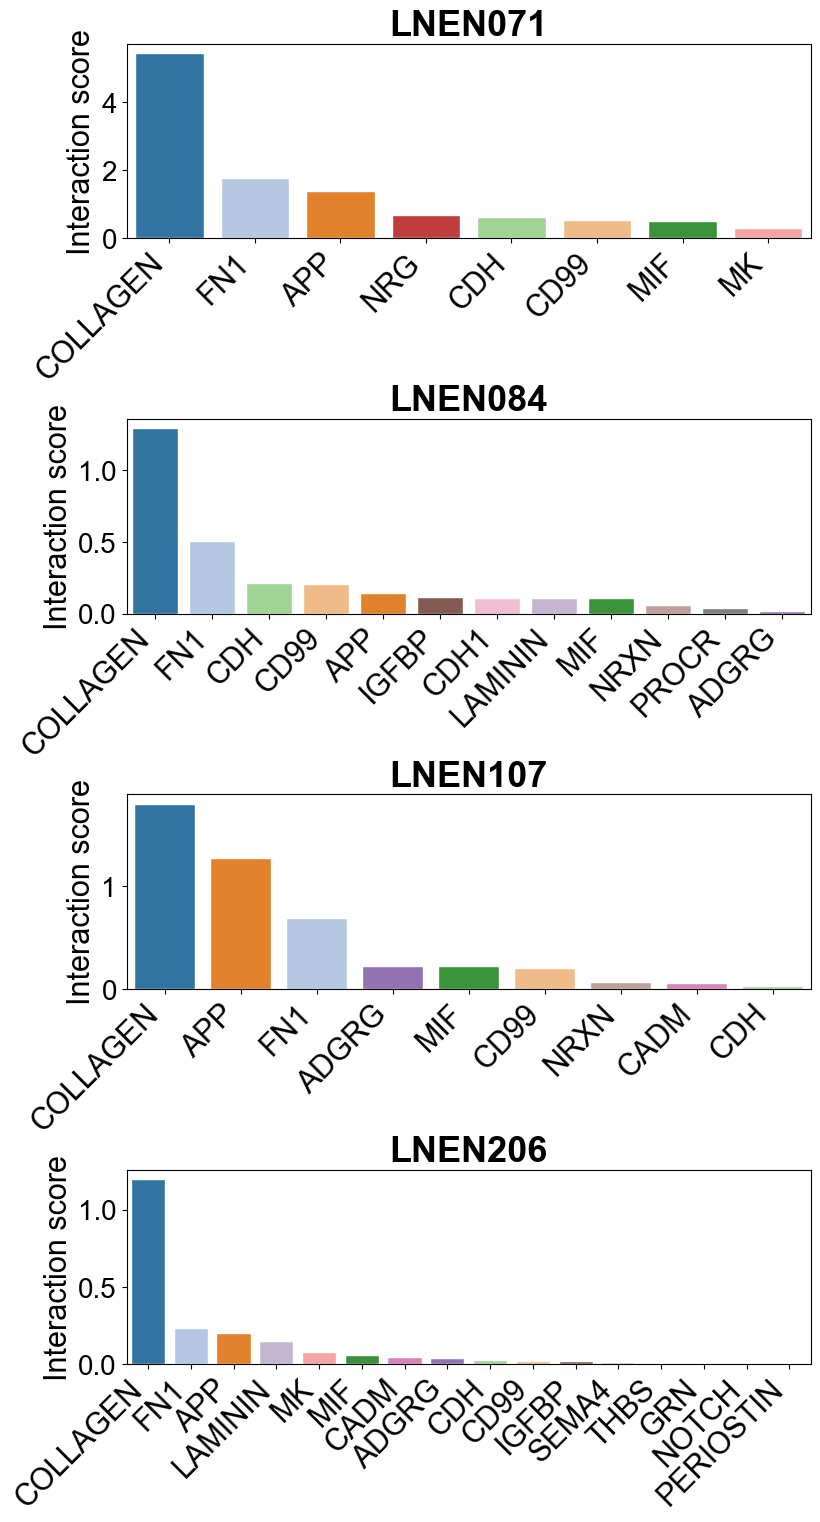

In [27]:
# plot a barplot of interaction scores for top-scored pathways

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(8,15))

sample_names = ["LNEN071", "LNEN084", "LNEN107", "LNEN206"]

for i, top_inter in enumerate(top_interaction_list):
    summary_df = top_inter.groupby("pathway_name", as_index=False).agg(Interaction_score=("prob", "sum"))
    pathway_scores = summary_df.sort_values(by="Interaction_score", ascending=False)
    sns.set_style("ticks")
    #sns.set_context("paper")
    im = sns.barplot(pathway_scores, 
                x="pathway_name",
                y="Interaction_score",
                hue="pathway_name",
                palette=element_color_map,
                legend=False, 
                ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Interaction score", fontsize=22)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, fontsize=22, ha="right")  # Rotate & increase font size
    ax[i].tick_params(axis='y', labelsize=20)  
    ax[i].set_title(sample_names[i], fontsize=26, fontweight="bold")
    #ax[i].tick_params(axis='x', labelrotation=45)
#plt.xticks(fontsize=14, rotation=45, ha='right')

plt.tight_layout(pad=-0.1)
plt.savefig("Pathway_scores_NEW.svg", format="svg", bbox_inches="tight")

#### Exctract scores of signalling pathways common to all 4 samples

In [29]:
# extract common pathways

common_path = set(top_inter1["pathway_name"].unique())
for i, top_inter in enumerate(top_interaction_list):
    #print(top_inter["pathway_name"].unique())
    common_path = common_path.intersection(top_inter["pathway_name"].unique())
    #print(common_path)

print(list(common_path))
final_df = pd.DataFrame(index=sorted(common_path))

for i, top_inter in enumerate(top_interaction_list):
    common_inter = top_inter[top_inter["pathway_name"].isin(common_path)]
    summary_df = common_inter.groupby("pathway_name", as_index=False).agg(Interaction_score=("prob", "sum"))
    summary_df.rename(columns={"Interaction_score": f"Sample_{i+1}"}, inplace=True)
    summary_df.set_index("pathway_name", inplace=True)
    # Merge into the final DataFrame
    final_df = final_df.merge(summary_df, left_index=True, right_index=True, how="left")

print(final_df)

#final_df.to_csv("Common_pathways_scores.csv", index = True)

['COLLAGEN', 'APP', 'FN1', 'CD99', 'MIF', 'CDH']
          Sample_1  Sample_2  Sample_3  Sample_4
APP       1.402348  0.145854  1.275202  0.203303
CD99      0.526622  0.205225  0.201984  0.023542
CDH       0.611656  0.214478  0.028652  0.028563
COLLAGEN  5.458278  1.291376  1.806365  1.199379
FN1       1.770786  0.502557  0.692562  0.231632
MIF       0.512821  0.106498  0.223490  0.058877


#### Plot signalling genes

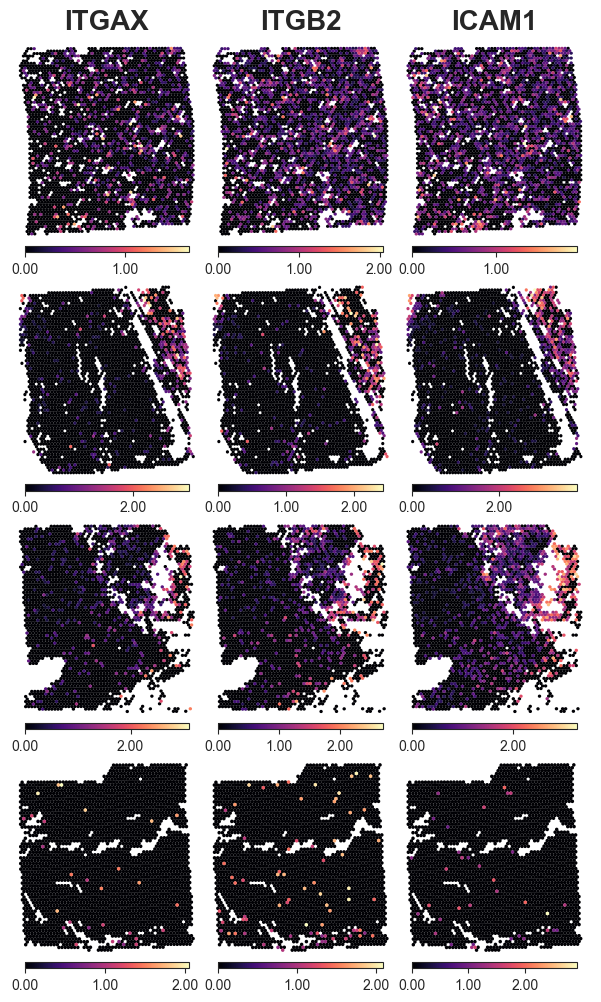

In [48]:
# plot MIF signalling genes

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(7.5,12))
#MIF_genes = ["MIF", "CD74", "CXCR4"]
signal_genes = ["ITGAX", "ITGB2", "ICAM1"]

for j, marker in enumerate(signal_genes):
    for i, lung_data in enumerate(lung_slices):
        sc.pl.spatial(lung_data, color=marker, 
                        size=1.7, 
                        cmap="magma", 
                        img_key=None, 
                        return_fig=True, 
                        show=False, 
                        ax=ax[i][j], 
                        title="", 
                        frameon=False, 
                        colorbar_loc = None
                        )
        # Add column title to each subplot
        ax[i][j].set_aspect("auto")
        if i == 0:  # Add titles only to the first row (or based on your preference)
            ax[i][j].set_title(marker, fontsize=20, fontweight='bold')  # Customize title as needed
            
        axins = inset_axes(ax[i][j],
                        width="85%",  
                        height="3%",
                        loc='lower center',
                        borderpad=-0.5
                        )
    
        cb = fig.colorbar(ax[i][j].collections[0], cax=axins, orientation="horizontal", format="{x:.2f}")
        cb.ax.tick_params(labelsize=10) 

#plt.tight_layout(pad=1)
plt.subplots_adjust(wspace=0.001, hspace=0.15)  # Adjust horizontal (wspace) and vertical (hspace) spacing

#plt.savefig("Signalling_genes_expression.png", format="png", bbox_inches="tight", dpi=300)

#### Plot spatial correlations for cell type proportions and expression of signalling genes

In [87]:
# load pre-computed correlation coefficients

corr_mat_list = []
p_val_list = []

for i in range(4):
    corr_mat = pd.read_csv(f'../results/correlation tables/Corr_genes_types{i}_NEW.csv', index_col=0)
    p_val = pd.read_csv(f'../results/correlation tables/Pval_genes_types{i}_NEW.csv', index_col=0)

    corr_mat_list.append(corr_mat)
    p_val_list.append(p_val)

corr_mat_list[0].head()

Lower Airway Progenitor  Neuroendocrine CALCA+  \
LPCAT1                 -0.011226              -0.057709   
SCGB3A2                 0.087872              -0.180946   
GPRC5A                  0.049605              -0.080088   
MIF                     0.047255              -0.008443   
CD74                   -0.065648              -0.159194   

         Neuroendocrine NEUROD1+      Club  Macrophage  \
LPCAT1                 -0.027663  0.021505   -0.020186   
SCGB3A2                -0.225087  0.098729    0.108875   
GPRC5A                 -0.118473  0.048067    0.056920   
MIF                    -0.084963  0.057082   -0.020253   
CD74                   -0.151341 -0.085495    0.194985   

         Macrophage_proliferating  Myofibro     Fibro    T_conv     T_CD8  \
LPCAT1                   0.042640  0.027380 -0.016581 -0.048953  0.029751   
SCGB3A2                  0.121198 -0.005662 -0.013726 -0.293176  0.020603   
GPRC5A                   0.049409  0.000910 -0.005728 -0.143490  0.028765   
MIF                     -0.037175 -0.022147 -0.017725 -0.082481  0.026764   
CD74                     0.198292  0.213848  0.203555  0.005681 -0.025968   

         T/NK_proliferating  
LPCAT1             0.055750  
SCGB3A2            0.261319  
GPRC5A             0.107831  
MIF                0.112646  
CD74              -0.021590

In [88]:
col_renaming_dict = {
    "Lower Airway Progenitor" : 'Lower Airway\nProgenitor',
    "Neuroendocrine CALCA+" : 'NE CALCA+',
    "Neuroendocrine NEUROD1+" : 'NE NEUROD1+', 
    "Macrophage_proliferating" : 'Macrophage\nproliferating',
    "T_conv" : "T conv",
    "T_CD8" : "T CD8",
    "T/NK_proliferating" : 'T/NK\nproliferating'
}

for i in range(4):
    corr_mat_list[i].rename(columns=col_renaming_dict, inplace=True)
    p_val_list[i].rename(columns=col_renaming_dict, inplace=True)

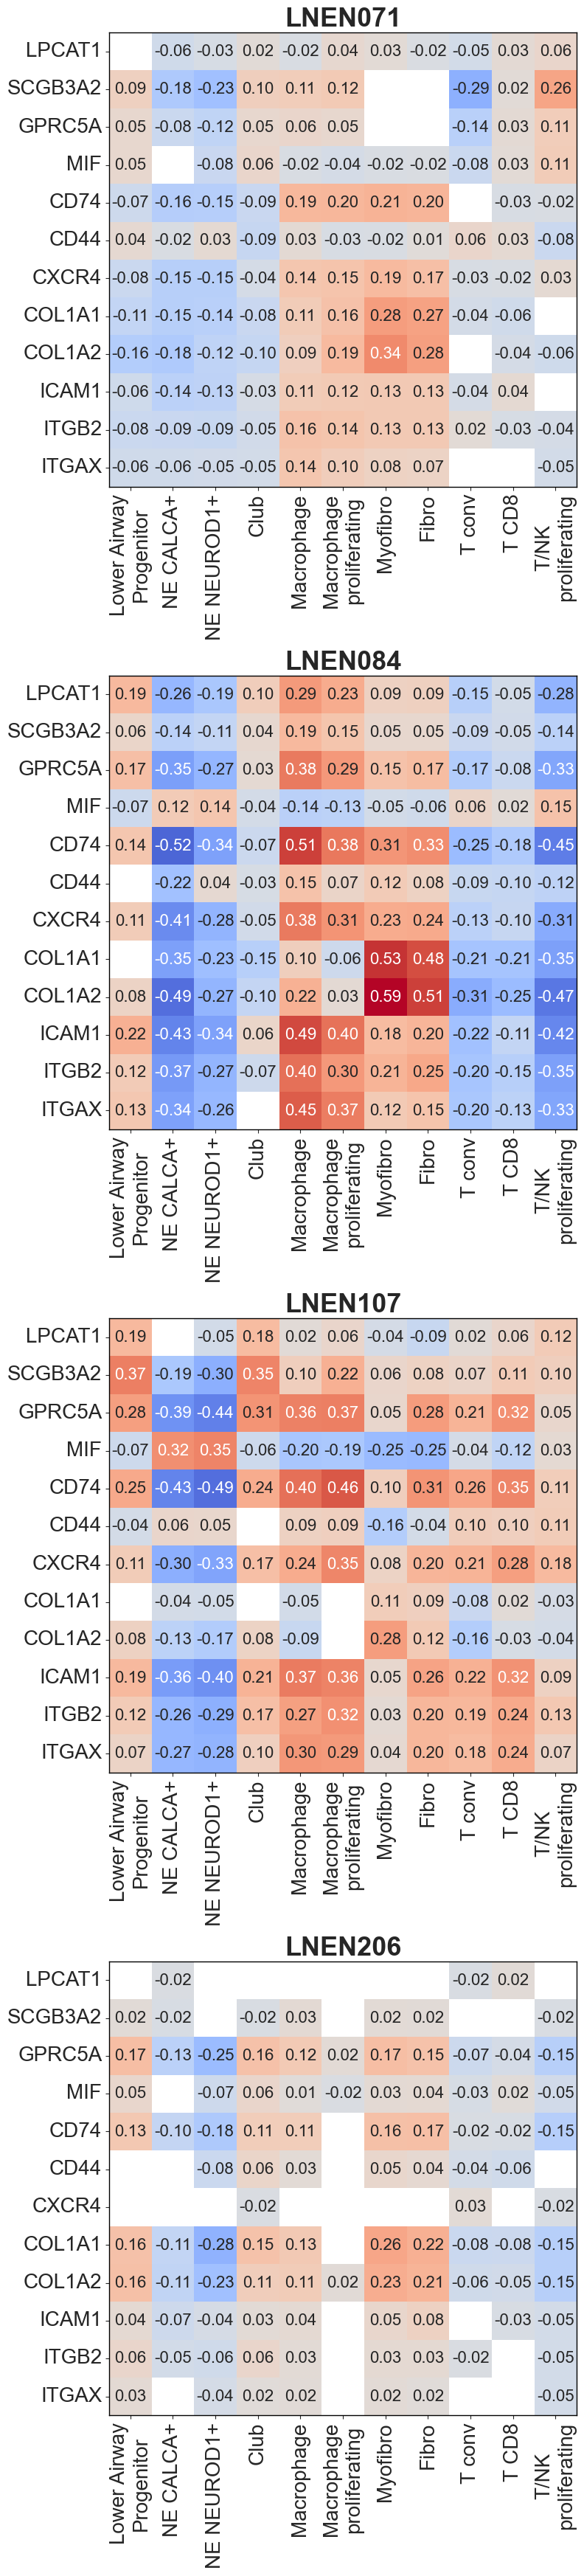

In [89]:
# plot genes-proportions correlations

sample_names = ["LNEN071", "LNEN084", "LNEN107", "LNEN206"]

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(8, 35))

# Find global min and max for consistent color scaling across all plots
all_corr_values = np.concatenate([mat.values.flatten() for mat in corr_mat_list])
vmin = np.min(all_corr_values)
vmax = np.max(all_corr_values)

# Optional: Symmetric scaling for better color balance around zero
abs_max = max(abs(vmin), abs(vmax))
vmin, vmax = -abs_max, abs_max

for i in range(4):
    df_corr = pd.DataFrame(corr_mat_list[i])
    df_pval = pd.DataFrame(p_val_list[i])

    mask = df_pval >= 0.05  # Hide non-significant values
    sns.set_style("ticks")

    g = sns.heatmap(df_corr, 
                annot = True, 
                cmap="coolwarm",
                mask=mask,
                fmt=".2f",   # Format values to 2 decimal places
                ax=ax[i],
                vmin=vmin,
                vmax=vmax,
                cbar=False,
                annot_kws={"size":16}
                )

    #cbar = g.collections[0].colorbar
    #if i==3:
    #    cbar = g.figure.colorbar(g.collections[0], location="bottom", fraction=0.02, pad=0.35)
    #    cbar.ax.set_title("Spatial cross-correlation", fontweight="bold")

    ax[i].set_title(sample_names[i], fontsize=26, fontweight='bold')

    g.set_xticklabels(g.get_xticklabels(), fontsize=20, rotation=90, ha="center")  # Column names
    g.set_yticklabels(g.get_yticklabels(), fontsize=20, rotation=0, ha="right")  # Row names

    for spine in g.spines.values():
    #    print(spine)
        spine.set_visible(True)
        spine.set_edgecolor("black")  # Set frame color
        spine.set_linewidth(1)        # Set frame thickness


plt.tight_layout(pad=1)
plt.savefig("../results/heatmaps/Correlation_heatmap_LAP_markers_signal_genes.svg", format="svg", bbox_inches="tight")


#### Plot correlation matrices for cell type proportions

In [91]:
# load pre-computed correlation coefficients

corr_mat_list_props = []
p_val_list_props = []

for i in range(4):
    corr_mat = pd.read_csv(f'../results/correlation tables/Corr_{i}_NEW.csv', index_col=0)
    p_val = pd.read_csv(f'../results/correlation tables/Pval_{i}_NEW.csv', index_col=0)

    corr_mat_list_props.append(corr_mat)
    p_val_list_props.append(p_val)

corr_mat_list_props[0].head()

Lower Airway Progenitor  Neuroendocrine CALCA+  \
Lower Airway Progenitor                 0.935717               0.008759   
Neuroendocrine CALCA+                   0.008759               0.843367   
Neuroendocrine NEUROD1+                 0.054324               0.324379   
Club                                    0.031900               0.132256   
Macrophage                             -0.020038              -0.245609   

                         Neuroendocrine NEUROD1+      Club  Macrophage  \
Lower Airway Progenitor                 0.054324  0.031900   -0.020038   
Neuroendocrine CALCA+                   0.324379  0.132256   -0.245609   
Neuroendocrine NEUROD1+                 0.867414 -0.205779   -0.326404   
Club                                   -0.205779  0.911201   -0.069200   
Macrophage                             -0.326404 -0.069200    0.652231   

                         Macrophage_proliferating  Myofibro     Fibro  \
Lower Airway Progenitor                 -0.190043 -0.379435 -0.221550   
Neuroendocrine CALCA+                   -0.256364 -0.377741 -0.441016   
Neuroendocrine NEUROD1+                 -0.282563 -0.450473 -0.351022   
Club                                    -0.080795 -0.116571 -0.248238   
Macrophage                               0.310440  0.172960  0.226438   

                           T_conv     T_CD8  T/NK_proliferating  
Lower Airway Progenitor  0.085662  0.150976            0.117464  
Neuroendocrine CALCA+    0.309630 -0.071511           -0.139148  
Neuroendocrine NEUROD1+  0.367688  0.134213           -0.425190  
Club                    -0.179191 -0.167273            0.195191  
Macrophage              -0.121558 -0.097455            0.106843

In [92]:
col_renaming_dict = {
    "Lower Airway Progenitor" : 'Lower Airway\nProgenitor',
    "Neuroendocrine CALCA+" : 'NE CALCA+',
    "Neuroendocrine NEUROD1+" : 'NE NEUROD1+', 
    "Macrophage_proliferating" : 'Macrophage\nproliferating',
    "T_conv" : "T conv",
    "T_CD8" : "T CD8",
    "T/NK_proliferating" : 'T/NK\nproliferating'
}

for i in range(4):
    corr_mat_list_props[i].rename(columns=col_renaming_dict, index=col_renaming_dict, inplace=True)
    p_val_list_props[i].rename(columns=col_renaming_dict, index=col_renaming_dict, inplace=True)

corr_mat_list_props[0]

Lower Airway\nProgenitor  NE CALCA+  NE NEUROD1+  \
Lower Airway\nProgenitor                   0.935717   0.008759     0.054324   
NE CALCA+                                  0.008759   0.843367     0.324379   
NE NEUROD1+                                0.054324   0.324379     0.867414   
Club                                       0.031900   0.132256    -0.205779   
Macrophage                                -0.020038  -0.245609    -0.326404   
Macrophage\nproliferating                 -0.190043  -0.256364    -0.282563   
Myofibro                                  -0.379435  -0.377741    -0.450473   
Fibro                                     -0.221550  -0.441016    -0.351022   
T conv                                     0.085662   0.309630     0.367688   
T CD8                                      0.150976  -0.071511     0.134213   
T/NK\nproliferating                        0.117464  -0.139148    -0.425190   

                               Club  Macrophage  Macrophage\nproliferating  \
Lower Airway\nProgenitor   0.031900   -0.020038                  -0.190043   
NE CALCA+                  0.132256   -0.245609                  -0.256364   
NE NEUROD1+               -0.205779   -0.326404                  -0.282563   
Club                       0.911201   -0.069200                  -0.080795   
Macrophage                -0.069200    0.652231                   0.310440   
Macrophage\nproliferating -0.080795    0.310440                   0.513506   
Myofibro                  -0.116571    0.172960                   0.306373   
Fibro                     -0.248238    0.226438                   0.259698   
T conv                    -0.179191   -0.121558                  -0.179106   
T CD8                     -0.167273   -0.097455                  -0.070674   
T/NK\nproliferating        0.195191    0.106843                   0.101401   

                           Myofibro     Fibro    T conv     T CD8  \
Lower Airway\nProgenitor  -0.379435 -0.221550  0.085662  0.150976   
NE CALCA+                 -0.377741 -0.441016  0.309630 -0.071511   
NE NEUROD1+               -0.450473 -0.351022  0.367688  0.134213   
Club                      -0.116571 -0.248238 -0.179191 -0.167273   
Macrophage                 0.172960  0.226438 -0.121558 -0.097455   
Macrophage\nproliferating  0.306373  0.259698 -0.179106 -0.070674   
Myofibro                   0.889116  0.571226 -0.152510 -0.145171   
Fibro                      0.571226  0.692703 -0.198069 -0.026947   
T conv                    -0.152510 -0.198069  0.985716 -0.012011   
T CD8                     -0.145171 -0.026947 -0.012011  0.944708   
T/NK\nproliferating       -0.008790 -0.003444 -0.338112 -0.242386   

                           T/NK\nproliferating  
Lower Airway\nProgenitor              0.117464  
NE CALCA+                            -0.139148  
NE NEUROD1+                          -0.425190  
Club                                  0.195191  
Macrophage                            0.106843  
Macrophage\nproliferating             0.101401  
Myofibro                             -0.008790  
Fibro                                -0.003444  
T conv                               -0.338112  
T CD8                                -0.242386  
T/NK\nproliferating                   0.922937

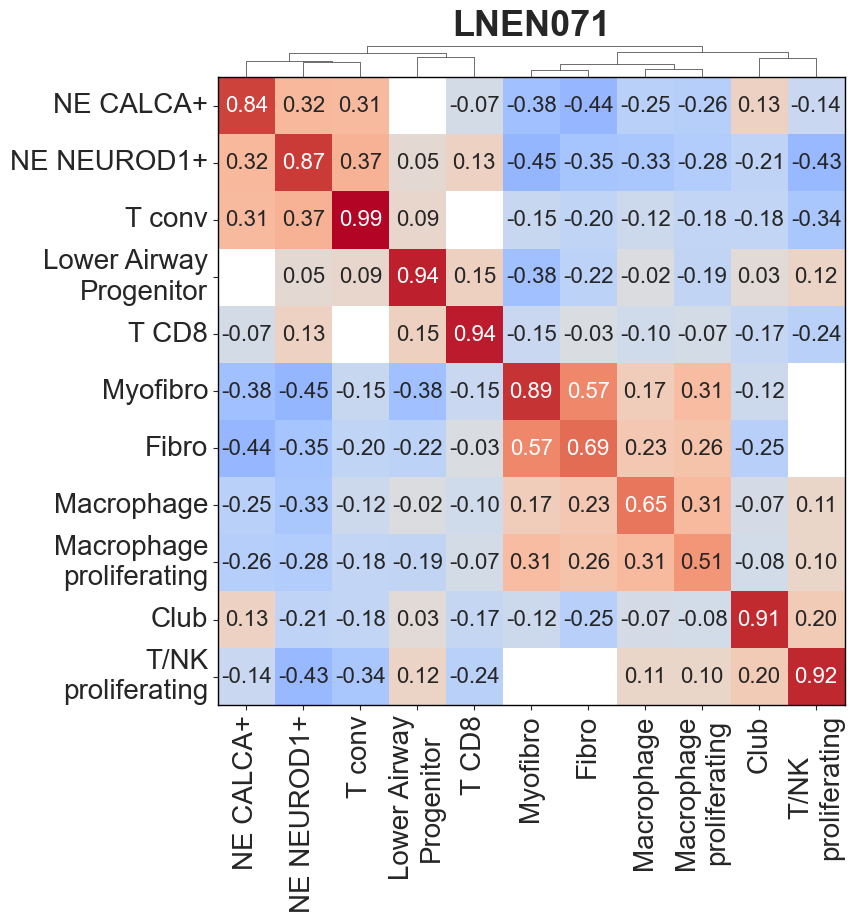

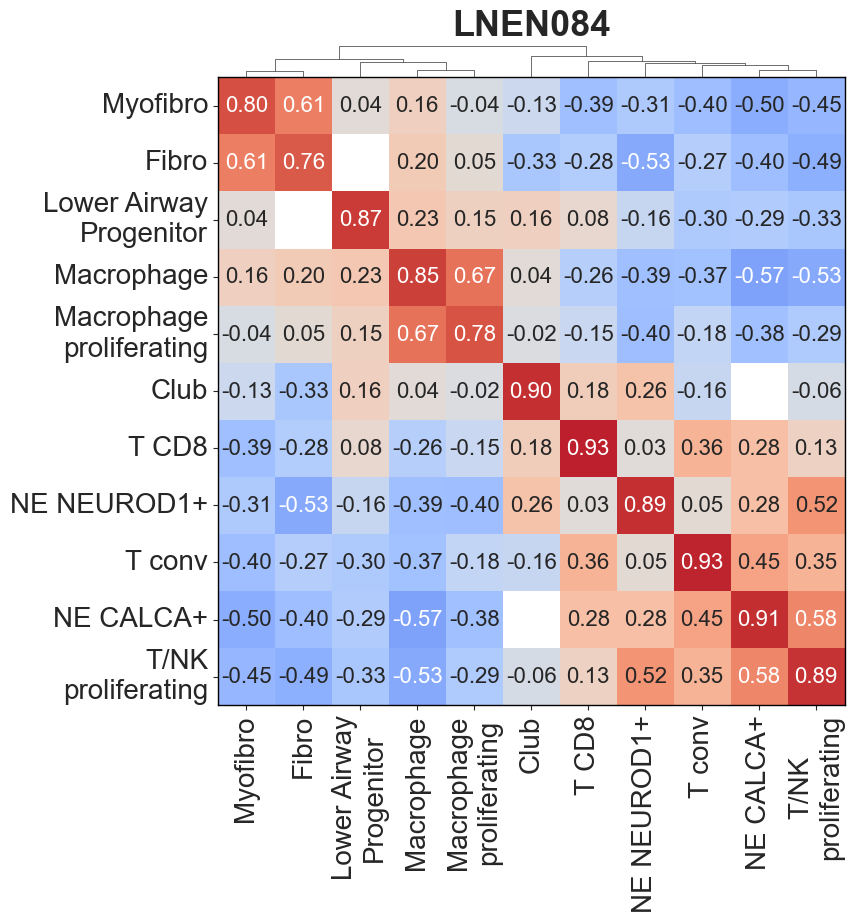

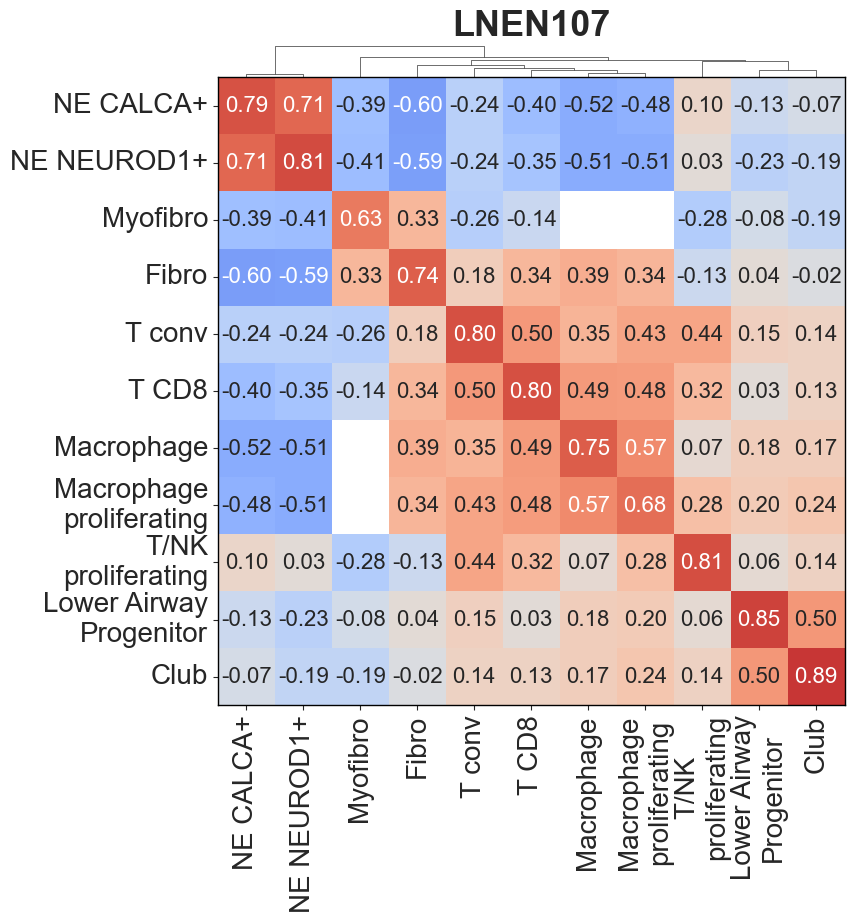

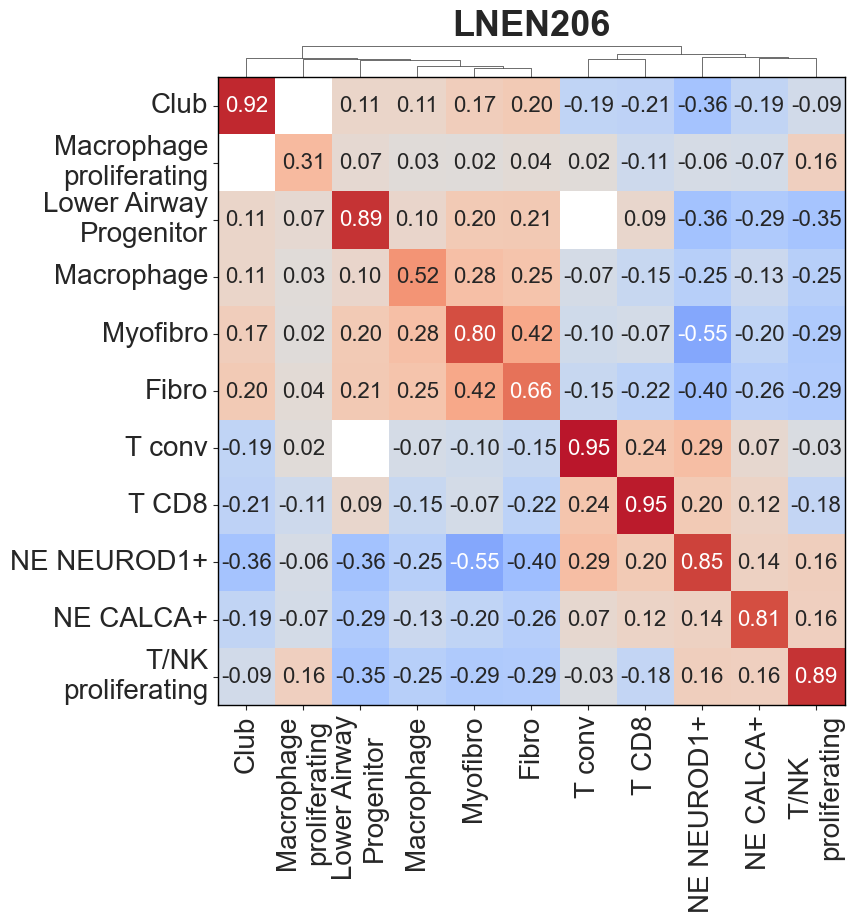

In [93]:
# Find global min and max for consistent color scaling across all plots
all_corr_values = np.concatenate([mat.values.flatten() for mat in corr_mat_list_props])
vmin = np.min(all_corr_values)
vmax = np.max(all_corr_values)

# Optional: Symmetric scaling for better color balance around zero
abs_max = max(abs(vmin), abs(vmax))
vmin, vmax = -abs_max, abs_max

for i in range(4):
    df_corr = corr_mat_list_props[i]
    df_pval = p_val_list_props[i]

    mask = df_pval >= 0.05  # Hide non-significant values
    sns.set_style("ticks")

    g = sns.clustermap(df_corr, 
                annot = True, 
                cmap="coolwarm",
                mask=mask,
                cbar_pos=None,
                vmin=vmin,
                vmax=vmax,
                #linewidths=0.5,
                linecolor="black",
                dendrogram_ratio=0.05,
                figsize=(8,8),
                fmt=".2f",   # Format values to 2 decimal places
                annot_kws={"size": 16},  # Increase font size of the annotations
                )
 
    g.ax_row_dendrogram.remove()
    g.ax_heatmap.set_title(sample_names[i], fontsize=26, fontweight='bold', pad=30)

    g.ax_heatmap.yaxis.set_label_position("left")
    g.ax_heatmap.yaxis.tick_left()

    # Change font size of row and column labels
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20, rotation=90, ha="center")  # Column names
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20, rotation=0, ha="right")  # Row names

    """
    if i == 3:
        cbar = g.figure.colorbar(g.ax_heatmap.collections[0], location="bottom", fraction=0.02, pad=0.35)
        cbar.ax.set_title("Spatial cross-correlation", fontweight="bold")
    """
    #plt.xticks(rotation=45, ha="right")
    for spine in g.ax_heatmap.spines.values():
    #    print(spine)
        spine.set_visible(True)
        spine.set_edgecolor("black")  # Set frame color
        spine.set_linewidth(1)        # Set frame thickness
    plt.savefig(f"../results/heatmaps/clustered_heatmaps_types_{i}.svg", format="svg", bbox_inches="tight")